<div style="background-color:#B2EBF2; color:black;  font-size:10pt; border: 1px solid #35BDD0; border-radius: 5px; padding:10px" /div>
 <b>Распределение адресов пациентов по географическим координатам (для привязки к участкам)

In [27]:
'''В программе реализован реальный кейс привязки пациентов, к которым совершаются визиты врачей в г.Москве.
Для определения визитов по районам и назначения бригад выделяются группы пациентов, объединенные территориальным признаком.
Далее возможно выделение дат, в которые необходим плановый визит, нанесение на карту и составление маршрута движения бригады. '''

'В программе реализован реальный кейс привязки пациентов, к которым совершаются визиты врачей в г.Москве.\nДля определения визитов по районам и назначения бригад выделяются группы пациентов, объединенные территориальным признаком.\nДалее возможно выделение дат, в которые необходим плановый визит, нанесение на карту и составление маршрута движения бригады. '

In [4]:
# pip install pandas scikit-learn


In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from IPython.display import display_markdown
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
df_emias = pd.read_excel('Протокол ЕМИАС все визиты_20241225.xlsx')

In [3]:
df_odrp = pd.read_excel('ОВПРП_адреса_1.xlsx')

In [4]:
df_odrp.columns

Index(['Дата включения пациента в Реестр', 'ФИО пациента', 'ID пациента',
       'Пол', 'Дата рождения', 'Гражданский статус',
       'Адрес регистрации по месту жительства',
       'Адрес регистрации по месту пребывания в Москве или адрес фактического места жительства в Москве',
       'Вид документа', 'Номер документа, удостоверяющего личность', 'СНИЛС',
       'Полис ОМС', 'Инвалидность', 'ФИО контактного лица',
       'Степень родства контактного лица',
       'Контактный телефон контактного лица', 'Наличие социального работника',
       'Контактные данные социального работника',
       'Прикрепление к патронажному участку ',
       'Дата прикрепления к патронажному участку',
       'МО патронажного прикрепления',
       'МО прикрепления онкологического профиля',
       'Медицинское заключение о наличии у пациента показаний для оказания паллиативной медицинской помощи ',
       'Дата выдачи заключения',
       'Наименование медицинской организации, выдавшей медицинское заключение',

In [5]:
df_em_i_od = df_emias.merge(df_odrp[['ФИО пациента','ID пациента','Полис ОМС','Адрес Yandex_adres', 'Долгота_adres', 'Широта_adres', 'Геоточки_adres',]], how='left', left_on='ID пациента', right_on='ID пациента')

In [6]:
df_em_i_od_full = df_em_i_od[~df_em_i_od['ФИО пациента'].isna()]
df_em_i_od_full.shape

(1685, 41)

In [16]:
# ---------------------------------------------------------- 
# df_5bud_viz_odrp = df_em_i_od_full[df_em_i_od_full['план_дата_визит_врач'].isin(['2024-12-26','2024-12-27','2024-12-28','2024-12-29','2024-12-30'])]
df_5bud_viz_odrp = df_em_i_od_full[df_em_i_od_full['план_дата_визит_врач'].isna()]
df_5bud_viz_odrp.shape

(465, 41)

In [17]:
# -------------------------------------------------------------- Считаем категории -----------------------------

In [18]:
def delete_vibros(df): 
    # Вычисляем IQR для долготы и широты
    Q1_longitude = df['Долгота_adres'].quantile(0.25)
    Q3_longitude = df['Долгота_adres'].quantile(0.75)
    IQR_longitude = Q3_longitude - Q1_longitude

    Q1_latitude = df['Широта_adres'].quantile(0.25)
    Q3_latitude = df['Широта_adres'].quantile(0.75)
    IQR_latitude = Q3_latitude - Q1_latitude

    # Определяем границы для выбросов
    lower_bound_longitude = Q1_longitude - 1.5 * IQR_longitude
    upper_bound_longitude = Q3_longitude + 1.5 * IQR_longitude

    lower_bound_latitude = Q1_latitude - 1.5 * IQR_latitude
    upper_bound_latitude = Q3_latitude + 1.5 * IQR_latitude

    # Фильтруем DataFrame, чтобы удалить выбросы
    df_filtered = df[
        (df['Долгота_adres'] >= lower_bound_longitude) & (df['Долгота_adres'] <= upper_bound_longitude) &
        (df['Широта_adres'] >= lower_bound_latitude) & (df['Широта_adres'] <= upper_bound_latitude)
    ]

    return df_filtered

In [19]:
# ------------------ Откинем выбросы ----------------------
df_5bud_viz_odrp = delete_vibros(df_5bud_viz_odrp)

In [20]:
# Извлеките координаты
coordinates = df_5bud_viz_odrp[['Долгота_adres', 'Широта_adres']].values

In [21]:
# Стандартизируем данные
scaler = StandardScaler()
coordinates_scaled = scaler.fit_transform(coordinates)

In [22]:
# Применяем K-Means
kmeans = KMeans(n_clusters=3, random_state=42)  # Указываем количество кластеров
df_5bud_viz_odrp['cluster'] = kmeans.fit_predict(coordinates_scaled)

In [23]:
df_5bud_viz_odrp['cluster'].unique()

array([0, 1, 2])

In [24]:
df_5bud_viz_odrp.shape

(446, 42)

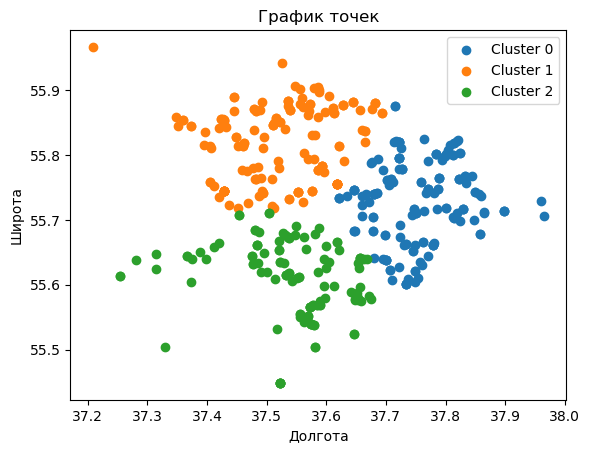

In [25]:
# Построение графика точек
for cluster in df_5bud_viz_odrp['cluster'].unique():
    cluster_df = df_5bud_viz_odrp[df_5bud_viz_odrp['cluster'] == cluster]
    plt.scatter(cluster_df['Долгота_adres'], cluster_df['Широта_adres'], label=f'Cluster {cluster}')

plt.xlabel('Долгота')
plt.ylabel('Широта')
plt.title('График точек')
plt.legend()
plt.show()

In [131]:
df_5bud_viz_odrp.to_excel('df_5bud_viz_odrp.xlsx')